In [1]:
!conda activate tf

In [2]:
import os
import pickle
import random
import json

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
import tensorflow_models as tfm
import tensorflow_hub as hub
import tensorflow_datasets as tfds

from sklearn.model_selection import train_test_split

tfds.disable_progress_bar()

In [3]:
batch_size = 2
eval_batch_size = 2
epochs = 3

In [4]:
ds = tfds.load('mnist', split='train', shuffle_files=True)

In [5]:
#gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/v3/uncased_L-12_H-768_A-12"
#tf.io.gfile.listdir(gs_folder_bert)


In [6]:
gs_folder_bert = "bert_uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

['.git',
 '.gitattributes',
 'bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'config.json',
 'flax_model.msgpack',
 'pytorch_model.bin',
 'README.md',
 'vocab.txt']

In [7]:
#gpu = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(gpu[0], True)

In [8]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')

In [9]:
with open('user_data.pkl', 'rb') as f:
    users = pickle.load(f)

with open('train_data.pkl', 'rb') as f:
    data = pickle.load(f)

In [10]:
# we are just going to look at the top 50 users
common_users = sorted([(x[0],len(x[1])) for x in users.items()], key= lambda y: y[1], reverse = True)
tweets_top_users = []
for user in common_users[50:52]:
  for tweet in users[user[0]]:
    tweets_top_users.append((user[0], tweet))

In [11]:
data_format = {"sentence1": [], "sentence2": [], "label": []}
for index, i in enumerate(tweets_top_users):
  for j in tweets_top_users[index+1:]:
    sentences = [i[1], j[1]]
    random.shuffle(sentences)
    data_format["sentence1"].append(sentences[0])
    data_format["sentence2"].append(sentences[1])
    data_format["label"].append(int(i[0]==j[0]))

In [12]:
data_pd = pd.DataFrame.from_dict(data_format)
data_pd = data_pd.sample(frac=1).reset_index(drop=True)
train_pd, test_pd = train_test_split(data_pd, test_size=0.2)

In [13]:
data_pd.head()

,sentence1,sentence2,label
0,"b""@mhaemee NO JOKE?! I thought you're younger....","b""@theDebbyRyan OHMYGOD THANK YOU YOU'RE SO AW...",1
1,b'@matthewmoloney ooo so shes got a few more i...,"b""http://twurl.nl/l8ekn3 Tweet tweet tweet tim...",0
2,"b""@anambanana Okayy! We're on our way. ) I thi...","b""@dougiemcfly Can i just ask.. why does McFly...",1
3,"b'http://twitpic.com/6vqc1 - CLASSMATES! Yay, ...",b'http://twitpic.com/5ey3r - @mishashi We met ...,1
4,b'#SFTW prawns yukky mush with tea even yukkier ',"b""@jaaaaayehm Me too! Hahaha. I can't believe ...",0


In [14]:
dataset = tf.data.Dataset.from_tensor_slices(dict(data_pd))
dataset_batch = dataset.batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(dict(test_pd)).batch(batch_size, drop_remainder=True)
train_dataset = tf.data.Dataset.from_tensor_slices(dict(train_pd)).batch(batch_size, drop_remainder=True)

In [15]:
next(iter(dataset_batch))

{'sentence1': <tf.Tensor: shape=(2,), dtype=string, numpy=
 array([b"@mhaemee NO JOKE?! I thought you're younger. Peeaaccee.  Shouldn't i be the one to wish you luck? Hahah!",
        b'@matthewmoloney ooo so shes got a few more inches to go then '],
       dtype=object)>,
 'sentence2': <tf.Tensor: shape=(2,), dtype=string, numpy=
 array([b"@theDebbyRyan OHMYGOD THANK YOU YOU'RE SO AWESOME!! ",
        b"http://twurl.nl/l8ekn3 Tweet tweet tweet time to vote for Archie!! From 7th place, he's now 5th! Just click @DavidArchie. "],
       dtype=object)>,
 'label': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([1, 0], dtype=int64)>}

In [16]:
tokenizer = tfm.nlp.layers.FastWordpieceBertTokenizer(
    vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
    lower_case=True)

In [17]:
max_seq_length = 256

packer = tfm.nlp.layers.BertPackInputs(
    seq_length=max_seq_length,
    special_tokens_dict = tokenizer.get_special_tokens_dict())

In [18]:
class BertInputProcessor(tf.keras.layers.Layer):
  def __init__(self, tokenizer, packer):
    super().__init__()
    self.tokenizer = tokenizer
    self.packer = packer

  def call(self, inputs):
    tok1 = self.tokenizer(inputs['sentence1'])
    tok2 = self.tokenizer(inputs['sentence2'])
    packed = self.packer([tok1, tok2])

    if 'label' in inputs:
      return packed, tf.convert_to_tensor(inputs['label'])
    else:
      return packed

In [19]:
bert_inputs_processor = BertInputProcessor(tokenizer, packer)

In [20]:
train_cw = train_dataset.map(bert_inputs_processor).prefetch(1)
test_cw = test_dataset.map(bert_inputs_processor).prefetch(1)

In [21]:
print(len(train_cw))
print(len(test_cw))

18180
4545


In [22]:
example_inputs, example_labels = next(iter(test_cw))

In [23]:
for key, value in example_inputs.items():
  print(f'{key:15s} shape: {value.shape}')

print(f'{"labels":15s} shape: {example_labels.shape}')

input_word_ids  shape: (2, 256)
input_mask      shape: (2, 256)
input_type_ids  shape: (2, 256)
labels          shape: (2,)


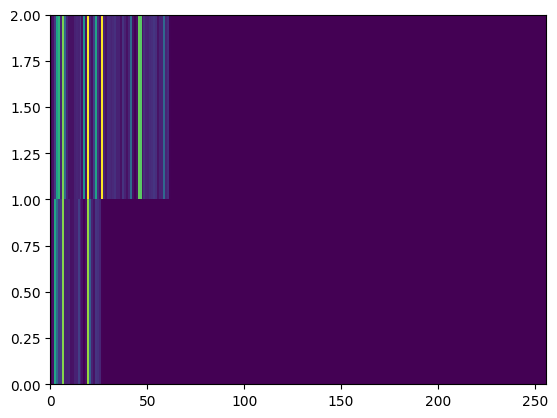

In [24]:
plt.pcolormesh(example_inputs['input_word_ids'])

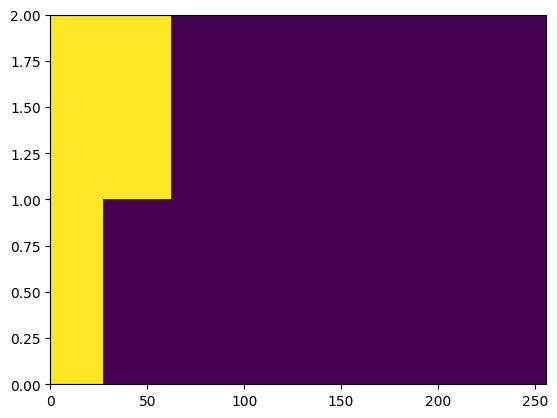

In [25]:
plt.pcolormesh(example_inputs['input_mask'])

In [26]:
bert_config_file = os.path.join(gs_folder_bert,"bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())
config_dict

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

In [27]:
encoder_config = tfm.nlp.encoders.EncoderConfig({
    'type':'bert',
    'bert': config_dict
})

In [28]:
bert_encoder = tfm.nlp.encoders.build_encoder(encoder_config)
bert_encoder

In [29]:
bert_classifier = tfm.nlp.models.BertClassifier(network=bert_encoder, num_classes=2)

In [30]:
bert_classifier(
    example_inputs, training=True).numpy()[:10]

array([[-0.4077384 ,  0.55496883],
       [-0.7053325 ,  1.2002751 ]], dtype=float32)

In [31]:
#checkpoint = tf.train.Checkpoint(encoder=bert_encoder)
#checkpoint.read(
#    os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()

In [32]:
# Set up epochs and steps

train_data_size = len(train_pd)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(0.1 * num_train_steps)
initial_learning_rate=2e-5

In [33]:
print(train_data_size)
print(steps_per_epoch)

36360
18180


In [34]:
linear_decay = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=initial_learning_rate,
    end_learning_rate=0,
    decay_steps=num_train_steps)

In [35]:
warmup_schedule = tfm.optimization.lr_schedule.LinearWarmup(
    warmup_learning_rate = 0,
    after_warmup_lr_sched = linear_decay,
    warmup_steps = warmup_steps
)

Text(0, 0.5, 'Learning rate')

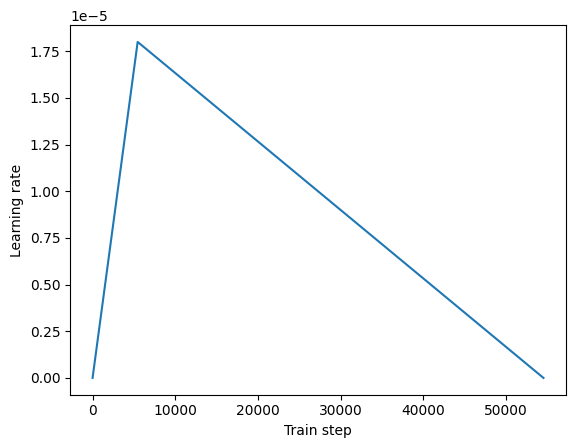

In [36]:
x = tf.linspace(0, num_train_steps, 1001)
y = [warmup_schedule(xi) for xi in x]
plt.plot(x,y)
plt.xlabel('Train step')
plt.ylabel('Learning rate')

In [37]:
optimizer = tf.keras.optimizers.experimental.Adam(
    learning_rate = warmup_schedule)

In [38]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

print(metrics)
print(loss)
print(optimizer)
bert_classifier.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

In [39]:
#bert_classifier.evaluate(test_cw)

In [40]:
thing = iter(train_cw)
for i in range(2):
    print(next(thing))

({'input_word_ids': <tf.Tensor: shape=(2, 256), dtype=int32, numpy=
array([[  101,  1030,  3335,  4168, 22772, 26095,  5292,  3270,  3270,
         3270,  2027,  2323,  2191,  1037, 10474,  4070,  1012,  2009,
         1005,  1055,  1996, 25551,  2126,  2000,  7532,  2000,  2037,
         4599,  1012,   102,  2027,  2020, 10218,  4000,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
         

In [41]:
bert_classifier.fit(
      train_cw,
      validation_data=(test_cw),
      batch_size=batch_size,
      epochs=epochs,
      )

Epoch 1/3


InternalError: Graph execution error:

Detected at node 'StatefulPartitionedCall_199' defined at (most recent call last):
    File "c:\Users\Elisabeth\miniconda3\envs\tf\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\Elisabeth\miniconda3\envs\tf\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\Elisabeth\AppData\Roaming\Python\Python39\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\Elisabeth\AppData\Roaming\Python\Python39\site-packages\traitlets\config\application.py", line 985, in launch_instance
      app.start()
    File "C:\Users\Elisabeth\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\Elisabeth\AppData\Roaming\Python\Python39\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Elisabeth\miniconda3\envs\tf\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\Elisabeth\miniconda3\envs\tf\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\Elisabeth\miniconda3\envs\tf\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Elisabeth\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\Elisabeth\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\Elisabeth\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\Elisabeth\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\Elisabeth\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\Users\Elisabeth\AppData\Roaming\Python\Python39\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Elisabeth\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "C:\Users\Elisabeth\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "C:\Users\Elisabeth\AppData\Roaming\Python\Python39\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Elisabeth\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Elisabeth\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Elisabeth\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Elisabeth\AppData\Local\Temp\ipykernel_328\4232424123.py", line 1, in <module>
      bert_classifier.fit(
    File "c:\Users\Elisabeth\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Elisabeth\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\Elisabeth\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\Elisabeth\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Elisabeth\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\Elisabeth\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\Users\Elisabeth\miniconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_experimental\optimizer.py", line 481, in minimize
      self.apply_gradients(grads_and_vars)
    File "c:\Users\Elisabeth\miniconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_experimental\optimizer.py", line 940, in apply_gradients
      super().apply_gradients(grads_and_vars)
    File "c:\Users\Elisabeth\miniconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_experimental\optimizer.py", line 526, in apply_gradients
      self._internal_apply_gradients(grads_and_vars)
    File "c:\Users\Elisabeth\miniconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_experimental\optimizer.py", line 943, in _internal_apply_gradients
      tf.__internal__.distribute.interim.maybe_merge_call(
    File "c:\Users\Elisabeth\miniconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_experimental\optimizer.py", line 993, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "c:\Users\Elisabeth\miniconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_experimental\optimizer.py", line 988, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_199'
libdevice not found at ./libdevice.10.bc
	 [[{{node StatefulPartitionedCall_199}}]] [Op:__inference_train_function_61655]

when allocating tensor with shape[32,12,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc\n\t [[{{node bert_classifier_1/bert_encoder_1/transformer/layer_4/self_attention/softmax/Softmax}}]]\nHint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.\n [Op:__inference_train_function_260891]"